In [9]:
# -.-|m { output: false, input_fold: hide }
%load_ext pretty_jupyter

#Imports
import tensorflow as tf
from tensorflow.keras.applications.resnet_v2 import ResNet50V2, preprocess_input
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers import Rescaling, Resizing
from tensorflow.data.experimental import cardinality
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import RandomFlip, RandomRotation
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization

The pretty_jupyter extension is already loaded. To reload it, use:
  %reload_ext pretty_jupyter


# <div align="center" style="padding: 10px; font-weight: bold;">Introduction</div>

In this assignment, we will look into the detection of melanoma using a Convolutional Neural Network (CNN) by applying transfer learning with a pre-trained model. I decided using the <a href="https://www.kaggle.com/datasets/bhaveshmittal/melanoma-cancer-dataset/" target="_blank"><b>🔬Melanoma Cancer Image Dataset</b></a>. It consists of 13 900 high-resolution images in test and train sets, both divided in two categorical fodlers - Benign and Malignant. The test folders comprise ot 1 000 photos each. The images are uniformly sized at 224 x 224 pixels.

For the choice of the pre-trained model I searched for previous uses and researches. Based on the performance comparison in the <a href="https://www.biorxiv.org/content/10.1101/2020.05.22.110973v3" target="_blank"><b>Sagar (2020)</b></a> research I decided to opt for the <a href="https://keras.io/api/applications/resnet/#resnet50v2-function" target="_blank"><b>ResNet50V2</b></a> model.

# <div align="center" style="padding: 10px; font-weight: bold;">Pre-process</div>

## Defining variables

In [8]:
TRAIN_PATH = 'data/train'
TEST_PATH = 'data/test'
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 10
CHANNELS = 3
SEED = 21

## Reading the datasets

In [3]:
train_ds = image_dataset_from_directory(
  TRAIN_PATH,
  shuffle = True,
  seed = SEED,
  image_size = IMAGE_SIZE,
  batch_size = BATCH_SIZE
)

val_ds = image_dataset_from_directory(
  TEST_PATH,
  shuffle = True,
  seed = SEED,
  image_size = IMAGE_SIZE,
  batch_size = BATCH_SIZE
)

Found 11879 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


2024-03-24 22:55:38.021724: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-03-24 22:55:38.021765: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-03-24 22:55:38.021779: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-03-24 22:55:38.022921: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-03-24 22:55:38.024185: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [4]:
class_names = train_ds.class_names
print(class_names)

['Benign', 'Malignant']


## Plotting images

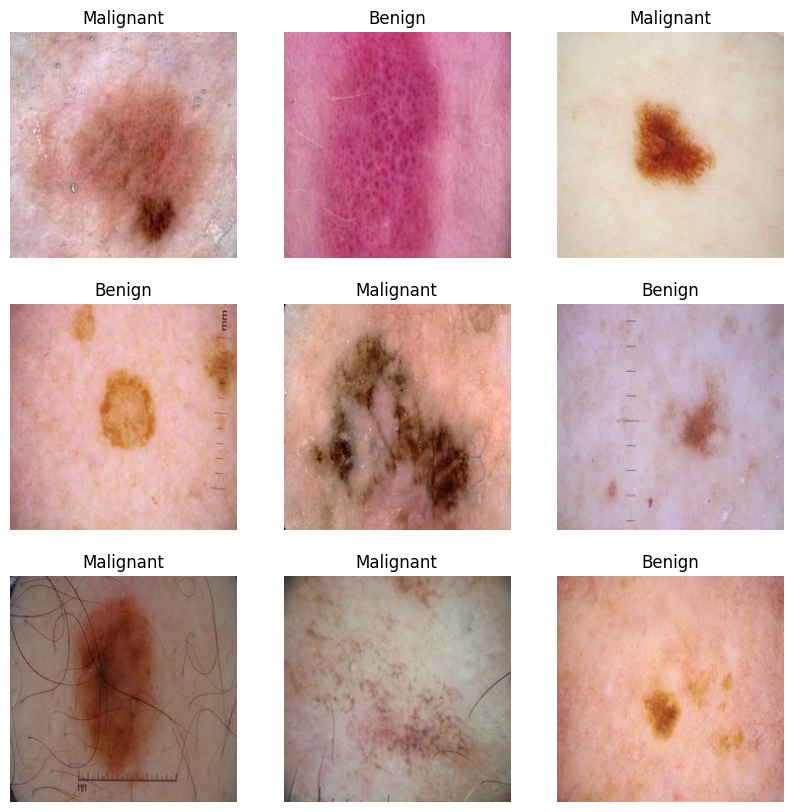

In [5]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

## Creation of test dataset from validation

In [6]:
val_batches = cardinality(val_ds)
test_ds = val_ds.take(val_batches // 5)
val_ds = val_ds.skip(val_batches // 5)

print('Number of validation batches: %d' % cardinality(val_ds))
print('Number of test batches: %d' % cardinality(test_ds))

Number of validation batches: 51
Number of test batches: 12


## Dataset performance optimization

In [7]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

## Data augmentation

We will apply some minor image transformation in order to expose the model to varying data examples in order to reduce overfitting. For this we use the RandomFlip and RandomRotation layers.

In [10]:
data_augmentation = Sequential([
  RandomFlip('horizontal'),
  RandomRotation(0.2),
])

## Image preprocessing

The ResNet50V2 model expects pixel values to be between -1 and 1. For this we will use the models <a href="https://www.tensorflow.org/api_docs/python/tf/keras/applications/resnet_v2/preprocess_input" target="_blank"><b>preprocess_input function</b></a> to prepare everything for us.

In [11]:
preprocess_input = preprocess_input

# <div align="center" style="padding: 10px; font-weight: bold;">Model</div>

## Creating the base model

In [14]:
IMAGE_SHAPE = IMAGE_SIZE + (3,)
base_model = ResNet50V2(input_shape=IMAGE_SHAPE,
                        include_top=False,
                        weights='imagenet')

94668760/94668760 [==============================] - 6s 0us/step


In [15]:
base_model.trainable = False

In [16]:
base_model.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 pool1_pad (ZeroPadding2D)   (None, 114, 114, 64)         0         ['conv1_conv[0][0]']          
                                                                                         